In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

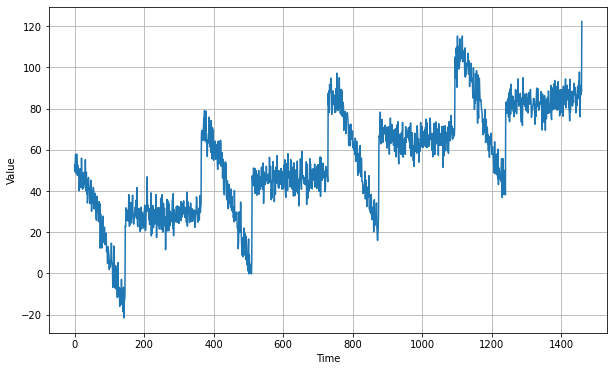

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
33/33 [==============================] - 3s 12ms/step - loss: 90.9191 - mae: 91.4191
Epoch 2/100
33/33 [==============================] - 0s 12ms/step - loss: 83.8978 - mae: 84.3978
Epoch 3/100
33/33 [==============================] - 0s 12ms/step - loss: 75.4974 - mae: 75.9974
Epoch 4/100
33/33 [==============================] - 0s 12ms/step - loss: 66.0676 - mae: 66.5676
Epoch 5/100
33/33 [==============================] - 0s 12ms/step - loss: 55.5131 - mae: 56.0131
Epoch 6/100
33/33 [==============================] - 0s 14ms/step - loss: 43.7599 - mae: 44.2597
Epoch 7/100
33/33 [==============================] - 0s 12ms/step - loss: 30.7909 - mae: 31.2900
Epoch 8/100
33/33 [==============================] - 0s 14ms/step - loss: 17.1478 - mae: 17.6436
Epoch 9/100
33/33 [==============================] - 0s 15ms/step - loss: 10.0311 - mae: 10.5178
Epoch 10/100
33/33 [==============================] - 0s 14ms/step - loss: 10.0607 - mae: 10.5524
Epoch 11/100
33/33 [=========

33/33 [==============================] - 0s 15ms/step - loss: 21.8978 - mae: 22.3929
Epoch 86/100
33/33 [==============================] - 1s 16ms/step - loss: 23.7963 - mae: 24.2939
Epoch 87/100
33/33 [==============================] - 1s 18ms/step - loss: 22.8037 - mae: 23.2998
Epoch 88/100
33/33 [==============================] - 1s 18ms/step - loss: 26.2572 - mae: 26.7556
Epoch 89/100
33/33 [==============================] - 0s 14ms/step - loss: 40.5868 - mae: 41.0838
Epoch 90/100
33/33 [==============================] - 1s 23ms/step - loss: 32.1696 - mae: 32.6679
Epoch 91/100
33/33 [==============================] - 1s 18ms/step - loss: 23.1459 - mae: 23.6421
Epoch 92/100
33/33 [==============================] - 0s 12ms/step - loss: 49.7284 - mae: 50.2244
Epoch 93/100
33/33 [==============================] - 0s 11ms/step - loss: 38.4224 - mae: 38.9214
Epoch 94/100
33/33 [==============================] - 0s 14ms/step - loss: 45.0525 - mae: 45.5519
Epoch 95/100
33/33 [=============

(1e-08, 0.0001, 0.0, 30.0)

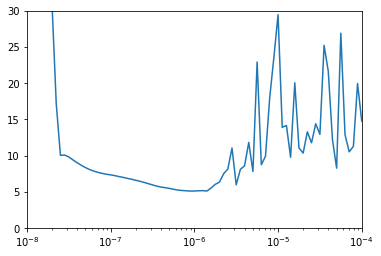

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
33/33 [==============================] - 3s 37ms/step - loss: 30.0122 - mae: 30.5050 - val_loss: 13.0810 - val_mae: 13.5746
Epoch 2/500
33/33 [==============================] - 0s 14ms/step - loss: 15.3618 - mae: 15.8570 - val_loss: 10.0991 - val_mae: 10.5941
Epoch 3/500
33/33 [==============================] - 1s 16ms/step - loss: 10.9284 - mae: 11.4173 - val_loss: 11.2192 - val_mae: 11.7083
Epoch 4/500
33/33 [==============================] - 1s 15ms/step - loss: 9.8165 - mae: 10.3052 - val_loss: 12.2806 - val_mae: 12.7757
Epoch 5/500
33/33 [==============================] - 0s 15ms/step - loss: 7.8424 - mae: 8.3317 - val_loss: 9.6437 - val_mae: 10.1336
Epoch 6/500
33/33 [==============================] - 1s 17ms/step - loss: 7.1708 - mae: 7.6561 - val_loss: 10.6124 - val_mae: 11.1036
Epoch 7/500
33/33 [==============================] - 1s 16ms/step - loss: 5.9200 - mae: 6.4041 - val_loss: 10.1595 - val_mae: 10.6522
Epoch 8/500
33/33 [==============================] - 1s 

33/33 [==============================] - 0s 14ms/step - loss: 4.8800 - mae: 5.3581 - val_loss: 7.7570 - val_mae: 8.2442
Epoch 63/500
33/33 [==============================] - 0s 14ms/step - loss: 4.8741 - mae: 5.3520 - val_loss: 7.7333 - val_mae: 8.2205
Epoch 64/500
33/33 [==============================] - 0s 14ms/step - loss: 4.8722 - mae: 5.3498 - val_loss: 7.6966 - val_mae: 8.1836
Epoch 65/500
33/33 [==============================] - 0s 14ms/step - loss: 4.8715 - mae: 5.3490 - val_loss: 7.6494 - val_mae: 8.1360
Epoch 66/500
33/33 [==============================] - 0s 14ms/step - loss: 4.8703 - mae: 5.3477 - val_loss: 7.5974 - val_mae: 8.0836
Epoch 67/500
33/33 [==============================] - 0s 14ms/step - loss: 4.8670 - mae: 5.3447 - val_loss: 7.5479 - val_mae: 8.0336
Epoch 68/500
33/33 [==============================] - 0s 14ms/step - loss: 4.8605 - mae: 5.3386 - val_loss: 7.5021 - val_mae: 7.9872
Epoch 69/500
33/33 [==============================] - 0s 14ms/step - loss: 4.8501 

33/33 [==============================] - 1s 17ms/step - loss: 4.5731 - mae: 5.0498 - val_loss: 6.3979 - val_mae: 6.8792
Epoch 124/500
33/33 [==============================] - 0s 14ms/step - loss: 4.5806 - mae: 5.0581 - val_loss: 6.3475 - val_mae: 6.8284
Epoch 125/500
33/33 [==============================] - 0s 14ms/step - loss: 4.5904 - mae: 5.0685 - val_loss: 6.2876 - val_mae: 6.7681
Epoch 126/500
33/33 [==============================] - 0s 14ms/step - loss: 4.5976 - mae: 5.0764 - val_loss: 6.2279 - val_mae: 6.7074
Epoch 127/500
33/33 [==============================] - 0s 14ms/step - loss: 4.6012 - mae: 5.0806 - val_loss: 6.1625 - val_mae: 6.6408
Epoch 128/500
33/33 [==============================] - 0s 14ms/step - loss: 4.6009 - mae: 5.0804 - val_loss: 6.1092 - val_mae: 6.5874
Epoch 129/500
33/33 [==============================] - 0s 14ms/step - loss: 4.5965 - mae: 5.0762 - val_loss: 6.0682 - val_mae: 6.5464
Epoch 130/500
33/33 [==============================] - 0s 15ms/step - loss: 

33/33 [==============================] - 1s 15ms/step - loss: 4.4777 - mae: 4.9560 - val_loss: 5.8716 - val_mae: 6.3483
Epoch 185/500
33/33 [==============================] - 0s 14ms/step - loss: 4.4720 - mae: 4.9500 - val_loss: 5.8624 - val_mae: 6.3389
Epoch 186/500
33/33 [==============================] - 0s 14ms/step - loss: 4.4672 - mae: 4.9447 - val_loss: 5.8582 - val_mae: 6.3347
Epoch 187/500
33/33 [==============================] - 0s 14ms/step - loss: 4.4631 - mae: 4.9401 - val_loss: 5.8564 - val_mae: 6.3328
Epoch 188/500
33/33 [==============================] - 0s 14ms/step - loss: 4.4601 - mae: 4.9368 - val_loss: 5.8563 - val_mae: 6.3327
Epoch 189/500
33/33 [==============================] - 0s 14ms/step - loss: 4.4579 - mae: 4.9344 - val_loss: 5.8564 - val_mae: 6.3328
Epoch 190/500
33/33 [==============================] - 0s 14ms/step - loss: 4.4564 - mae: 4.9328 - val_loss: 5.8560 - val_mae: 6.3324
Epoch 191/500
33/33 [==============================] - 0s 14ms/step - loss: 

33/33 [==============================] - 0s 14ms/step - loss: 4.3972 - mae: 4.8744 - val_loss: 5.5934 - val_mae: 6.0718
Epoch 246/500
33/33 [==============================] - 1s 18ms/step - loss: 4.4095 - mae: 4.8858 - val_loss: 5.8995 - val_mae: 6.3778
Epoch 247/500
33/33 [==============================] - 0s 14ms/step - loss: 4.3946 - mae: 4.8713 - val_loss: 5.5853 - val_mae: 6.0637
Epoch 248/500
33/33 [==============================] - 1s 16ms/step - loss: 4.4118 - mae: 4.8884 - val_loss: 5.8581 - val_mae: 6.3357
Epoch 249/500
33/33 [==============================] - 1s 26ms/step - loss: 4.3972 - mae: 4.8737 - val_loss: 5.5920 - val_mae: 6.0704
Epoch 250/500
33/33 [==============================] - 1s 22ms/step - loss: 4.4102 - mae: 4.8866 - val_loss: 5.9205 - val_mae: 6.3994
Epoch 251/500
33/33 [==============================] - 1s 32ms/step - loss: 4.3933 - mae: 4.8706 - val_loss: 5.5486 - val_mae: 6.0274
Epoch 252/500
33/33 [==============================] - 1s 20ms/step - loss: 

33/33 [==============================] - 1s 17ms/step - loss: 4.3755 - mae: 4.8528 - val_loss: 5.5800 - val_mae: 6.0593
Epoch 307/500
33/33 [==============================] - 0s 15ms/step - loss: 4.3606 - mae: 4.8364 - val_loss: 5.6763 - val_mae: 6.1575
Epoch 308/500
33/33 [==============================] - 0s 15ms/step - loss: 4.3522 - mae: 4.8282 - val_loss: 5.3801 - val_mae: 5.8612
Epoch 309/500
33/33 [==============================] - 0s 14ms/step - loss: 4.3721 - mae: 4.8490 - val_loss: 5.5760 - val_mae: 6.0555
Epoch 310/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3596 - mae: 4.8353 - val_loss: 5.6439 - val_mae: 6.1255
Epoch 311/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3518 - mae: 4.8279 - val_loss: 5.3755 - val_mae: 5.8567
Epoch 312/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3747 - mae: 4.8520 - val_loss: 5.5522 - val_mae: 6.0320
Epoch 313/500
33/33 [==============================] - 0s 14ms/step - loss: 

33/33 [==============================] - 1s 17ms/step - loss: 4.3542 - mae: 4.8302 - val_loss: 5.6235 - val_mae: 6.1038
Epoch 368/500
33/33 [==============================] - 0s 15ms/step - loss: 4.3489 - mae: 4.8241 - val_loss: 5.9567 - val_mae: 6.4375
Epoch 369/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3381 - mae: 4.8142 - val_loss: 5.3799 - val_mae: 5.8607
Epoch 370/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3605 - mae: 4.8375 - val_loss: 5.5902 - val_mae: 6.0698
Epoch 371/500
33/33 [==============================] - 0s 15ms/step - loss: 4.3507 - mae: 4.8266 - val_loss: 5.8497 - val_mae: 6.3294
Epoch 372/500
33/33 [==============================] - 1s 15ms/step - loss: 4.3361 - mae: 4.8119 - val_loss: 5.7482 - val_mae: 6.2289
Epoch 373/500
33/33 [==============================] - 0s 15ms/step - loss: 4.3367 - mae: 4.8117 - val_loss: 5.9942 - val_mae: 6.4761
Epoch 374/500
33/33 [==============================] - 0s 15ms/step - loss: 

In [9]:
model = keras.models.load_model("my_checkpoint.h5")

In [10]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

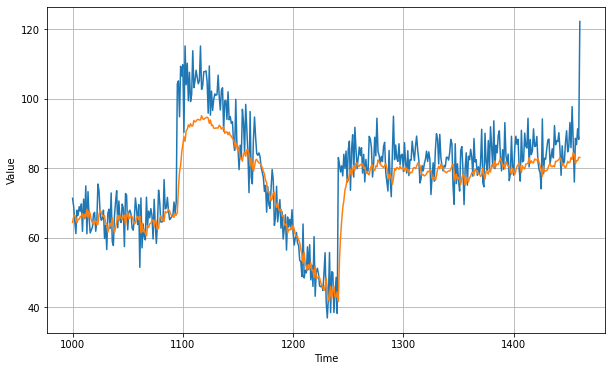

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.8760943